# K-Nearest Neighbors Applied

This experiment is inspired from the example discussed in __"Chapter 3. K-Nearest Neighbors" of ["Thoughtful Machine Learning with Python"](http://shop.oreilly.com/product/0636920039082.do) by Matthew Kirk__. The data provided with the book can be found in this [GitHub repo](https://github.com/thoughtfulml/examples-in-python/tree/master/k-nearest-neighbors).

## Supporting Libraries

In [1]:
import pandas as pd
import numpy as np

from scipy.spatial import KDTree
from sklearn import metrics

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import math
import random

%matplotlib inline

# Predict the value of houses in Seattle

### The challenge (Simplified)

Predict the value of houses in Seattle based on a limited set of attributes - specifically:

* the location of the house (lat/ long), 
* the size of the house (square foot).

__#supervised learning, #regression__

### About the data

The "data/data_simplified.csv" dataset is a simplification of the [original dataset](https://github.com/thoughtfulml/examples-in-python/tree/master/k-nearest-neighbors/data) provided in the book. 

The dataset includes the following data:

* __(response/ target)__ _AppraisedValue_, the house value in dollars
* __(predictor)__ the location of the house
    * _lat_, latituse
    * _long_, longitude
* __(predictor)__ _SqrFtLot_, the size of the house in square meters

The following pre-processing tasks have been applied on the data:

* removals of observations/ entries having __NA__ values

### Approach

#### KDTree: a KNN implementation

The idea is to use the KNN algorithm, specifically the KDTree ([Wikipedia](https://en.wikipedia.org/wiki/K-d_tree)) algorithm implementation for predicting the value of a house.

    'The k-d tree is a binary tree in which every node is a k-dimensional point. Every non-leaf node can be thought of as implicitly generating a splitting hyperplane that divides the space into two parts, known as half-spaces. Points to the left of this hyperplane are represented by the left subtree of that node and points right of the hyperplane are represented by the right subtree. The hyperplane direction is chosen in the following way: every node in the tree is associated with one of the k-dimensions, with the hyperplane perpendicular to that dimension's axis. So, for example, if for a particular split the "x" axis is chosen, all points in the subtree with a smaller "x" value than the node will appear in the left subtree and all points with larger "x" value will be in the right subtree. In such a case, the hyperplane would be set by the x-value of the point, and its normal would be the unit x-axis.' (Wikipedia)

#### Measuring Model Perfomance

Being a __regression problem__, the __metrics__ chosen for measuring the performance of the models are:

* the __mean absolute error__ (MAE), and
* the __R-squared__.


The __mean absolute error__ ([Wikipedia](https://en.wikipedia.org/wiki/Mean_absolute_error)) helps to __quantify the accuracy of the model__. It allows to say that the prediction is off by ... on average from the actual value. The __mean absolute error__ has the same unit of measure of the response variable.

The __R-squared__ [Wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_determination) helps to measure the proportion of variance explained by the model. It has a value between 0 and 1; if 0 the model is not able to explain any variance in the response (the worst model), if 1 the model is able to explain all of the variace in the response (the ideal model).

#### The prediction

The idea for predicting the value of a house is to find the K closest houses (based on the provided predictors) and estimate the value of the house as the mean of the values of the neighbor houses. In oder to find the K neighbors/ houses two questions need to be addressed:

* __How does closeness is defined?__

Closeness can be measured as the distance between two different entries. There are many distance definitions, for this challenge the __euclidean distance__ between two entries (Minkowski Distance with p = 2) is a reasonable choice.

* __How many neighbors are needed to make a prediction?__

For the selection of the number of neighbors a __"guessing approach"__ is used. The model predicts the value of the house as the mean value of the K neighbor houses.

### Load the data

In [2]:
data = pd.read_csv("data/data_simplified.csv")

### Simple Exploratory Data Analysis

__Basic information about the dataset__

In [3]:
#A quick summary of the dataframe and its content
#no of observations, variables(target + predictors)
#For each feature: feature name, no of non-null values, type 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17038 entries, 0 to 17037
Data columns (total 4 columns):
AppraisedValue    17038 non-null float64
lat               17038 non-null float64
long              17038 non-null float64
SqFtLot           17038 non-null int64
dtypes: float64(3), int64(1)
memory usage: 532.5 KB


__Univariate Analysis__

In [4]:
def print_basic_statistic(aSeries, aName):
    print("%s values:\n" % aName)
    print("\tMin: %r" % aSeries.min())
    print("\tMedian: %r" % aSeries.median())
    print("\tMean: %r" % aSeries.mean())
    print("\tMax: %r" % aSeries.max())

#Warning connected to Basemap using deprecated methods in matplotlib
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

def plotLocationsOnMap(longs, lats, 
                       llcrnrlon=-160.00, llcrnrlat=0.00,
                       urcrnrlon=120.00, urcrnrlat=70.00):
    
    my_map = Basemap(projection='merc', lat_0=47.6062, lon_0=-122.3321,
    resolution = 'l', area_thresh = 1000.0,
    llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
    urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)

    my_map.drawcoastlines()
    my_map.drawcountries()
    my_map.fillcontinents(color='grey')
    my_map.drawmapboundary()

    x,y = my_map(longs, lats)
    my_map.plot(x, y, 'bo', markersize=10)

    plt.gcf().set_size_inches(20, 12, forward=False)
    plt.show()

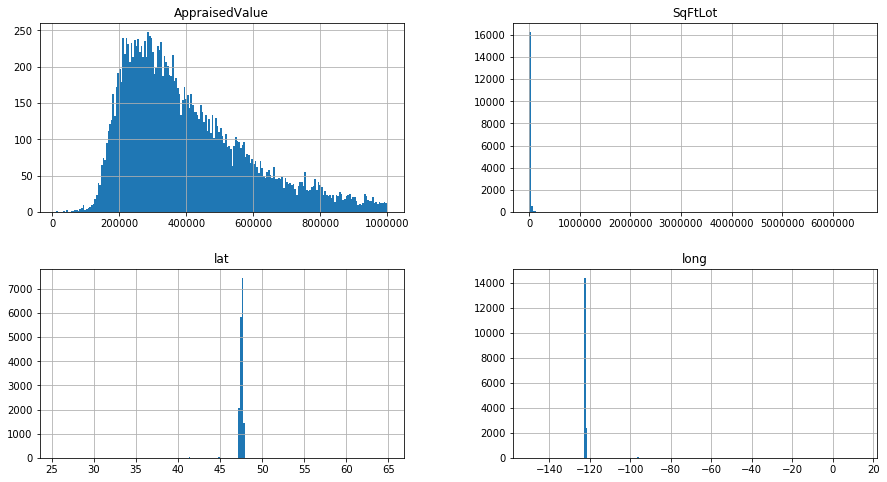

In [5]:
#variables distribution/ Univariate analysis
data.hist(bins=200, figsize=(15,8));

Looking at the distributions for __SqrFtLot__, __lat__ and __long__ some "peculiar" values must be present because of the value ranges on the x-axis.

In [6]:
#Looking at SqFtLot predictor: something strange in the data
print_basic_statistic(data.SqFtLot, "SqFtLot")

SqFtLot values:

	Min: 535
	Median: 8108.0
	Mean: 11930.446883437024
	Max: 6542712


Looking at basic statistic info about __SqFtLot__ - min, median, mean and max - the max value seems to be off. Actually it is the only value greater than 900000.

    _Cleaning: Remove entries with __SqFtLot__ greater than 900000_

In [7]:
#Location
#Looking at Latitude predictor
print_basic_statistic(data.lat, "Latitude")
print("\n")

#Looking at Longitude predictor
print_basic_statistic(data.long, "Longitude")

Latitude values:

	Min: 25.554839596152306
	Median: 47.55999183654785
	Mean: 47.465585930511295
	Max: 64.832940101623535


Longitude values:

	Min: -149.87251102924347
	Median: -122.23690795898438
	Mean: -121.8833360590335
	Max: 13.441879



When looking at latitude and longitude of the entries, we can see that there are entries that are not strictly located in the Seattle area (see map plot below for confimation) 

    _Cleaning: Limit the location area around Seattle (rough boundaries), 47 <= latitude <= 49 and -124 >= longitude <= -122

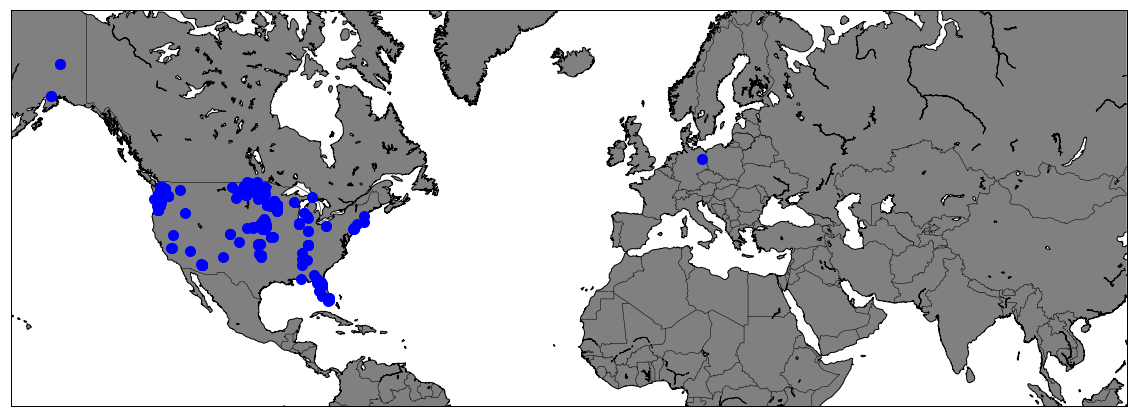

In [8]:
plotLocationsOnMap(data.long.tolist(), data.lat.tolist())
#the location of some entries seem to be off - something in Europe, all over USA, ...

__Bivariate Analysis__

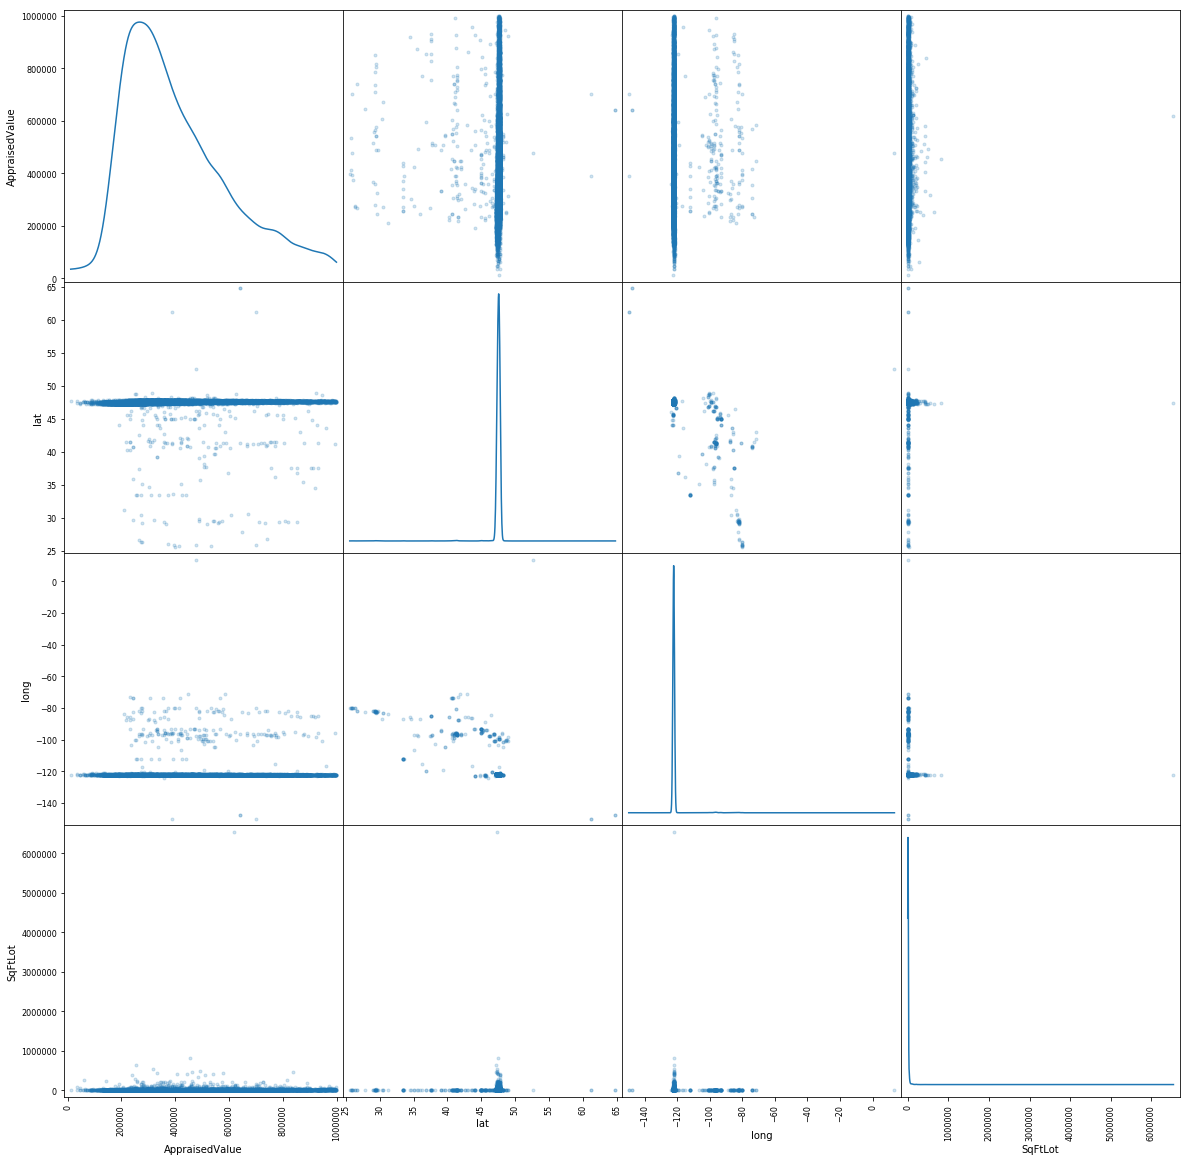

In [9]:
pd.scatter_matrix(data, alpha=0.2,figsize=(20,20), diagonal="kde");

__The different scale__ for the predictors could create problems when defining closeness between entries. For this reason it would be better to normalize the predictors.

An interesting experiment is to remove the normalization, fit and evaluate the model - the MAE is going to be much higher (almost double) than the MAE obtained normalizing the prdictors.

### Simple Cleaning/ Processing of the Data

Remove entries with SqFtLot > 900000 (value picked up from inspection)

In [10]:
data_cleaned = data[data.SqFtLot <= 900000]

Remove entries with locations outside of the Seattle area

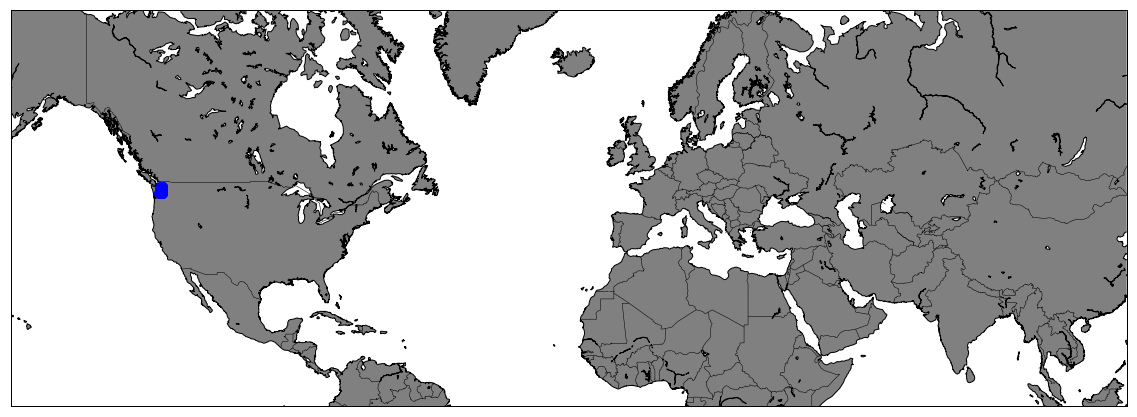

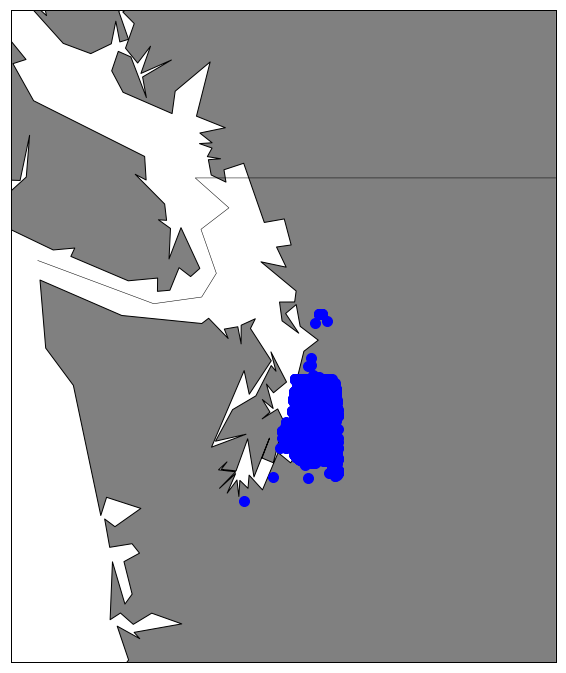

In [11]:
data_cleaned = data_cleaned[
    ((data_cleaned.lat <= 49.0) & (data_cleaned.lat >= 47.0)) &
    ((data_cleaned.long >= -124.0) & (data_cleaned.long <= -122.0))]

#All entries are within the delimited area
plotLocationsOnMap(data_cleaned.long.tolist(), data_cleaned.lat.tolist())

#Zooming-in in teh delimited area
plotLocationsOnMap(data_cleaned.long.tolist(), data_cleaned.lat.tolist(),
                llcrnrlon=-125.00, llcrnrlat=46.00,
                urcrnrlon=-120.00, urcrnrlat=50.00)

Normalize predictors values - centering and scaling- except the response/ target.

In [12]:
#Predictors Normalization with the exception of the response
tmp = data_cleaned.AppraisedValue
data_cleaned = (data_cleaned - data_cleaned.mean())/(data_cleaned.max()-data_cleaned.min())
data_cleaned.AppraisedValue = tmp

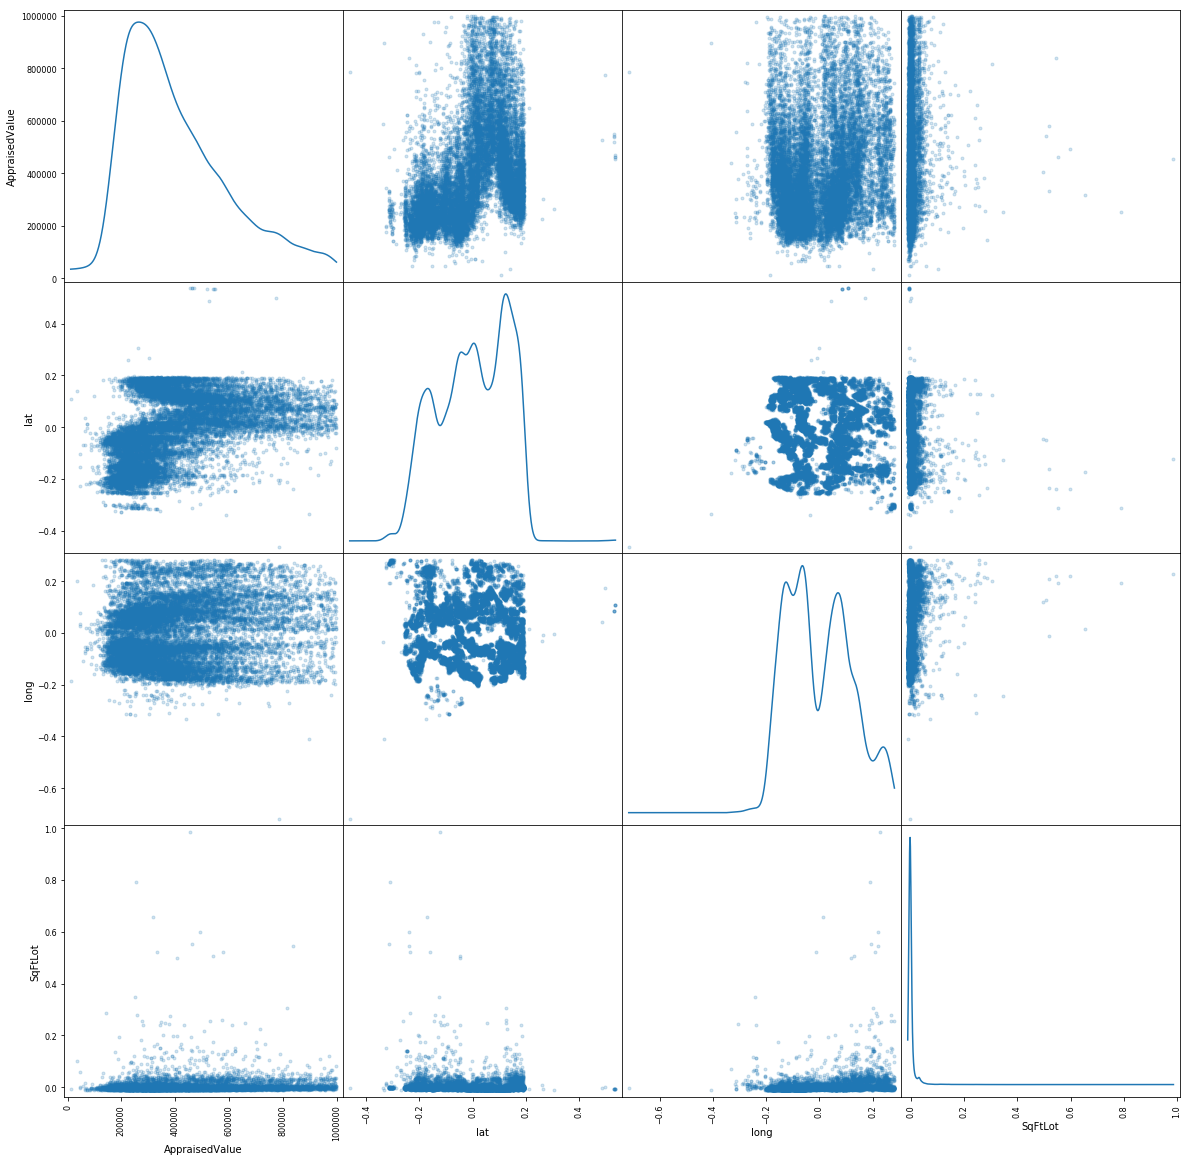

In [13]:
pd.scatter_matrix(data_cleaned, alpha=0.2,figsize=(20,20), diagonal="kde");

In [14]:
#After applying this simple rules the size of the dataset is
#from the original 17038 entries 
data_cleaned.shape

(16122, 4)

In [15]:
data_cleaned.to_csv("data/data_simplified_cleaned.csv", index=False)

## Model Training and Evaluation

### Training & Testing Data

The data has been split into two different sets using __random sampling__:

* 80% of the entries used as __training data__,
* 20% of the entries used as __testing data__.

In [16]:
def data_splitting(dataset,testing_holdout = 0.2, seed = 19711004):
    random.seed(seed)
    test_rows = random.sample(list(dataset.index), int(round(len(dataset) * testing_holdout)))
    train_rows = set(range(len(dataset))) - set(test_rows)
    testing = dataset.ix[test_rows]
    training = dataset.drop(test_rows)
    return (training, testing)

data_training, data_testing = data_splitting(dataset = data_cleaned, testing_holdout = 0.2)
print("\nTraining Size: %r" % str(data_training.shape))
print(data_training.info())
print("\nTesting Size: %r" % str(data_testing.shape))
print(data_testing.info())


Training Size: '(12898, 4)'
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12898 entries, 1 to 17036
Data columns (total 4 columns):
AppraisedValue    12898 non-null float64
lat               12898 non-null float64
long              12898 non-null float64
SqFtLot           12898 non-null float64
dtypes: float64(4)
memory usage: 503.8 KB
None

Testing Size: '(3224, 4)'
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3224 entries, 15530 to 563
Data columns (total 4 columns):
AppraisedValue    3224 non-null float64
lat               3224 non-null float64
long              3224 non-null float64
SqFtLot           3224 non-null float64
dtypes: float64(4)
memory usage: 125.9 KB
None


### Model Training

The K-NN is an example of a __nonparametric__ algorithm. There is actually no estimation of any parameter, the entries are organized in multiple sets in a multiplane based on the values of their predictor.

In [17]:
#Training
training_response = data_training.AppraisedValue
training_predictors = data_training.drop(["AppraisedValue"], 1)

#Testing
testing_response = data_testing.AppraisedValue
testing_predictors = data_testing.drop(["AppraisedValue"], 1)

In [18]:
kd_tree_model = KDTree(training_predictors)

### Evaluate the model

Using the testing entries, the model finds the k neighbor houses and calculate the predicted value for each testing entry as the mean of the value of the neighbor houses.

The predicted values is then compared to the actual value in order to estimate the mean squared error.

In [19]:
def predict(model, model_response, new_entry, k = 10):
    distance, indexes = model.query(new_entry, k)
    #print("\nNew Entry: %r" % new_entry.values)
    #print("\tK (%r) Neighbors" % k)
    #print("\tDistances: %r" % distance)
    #print("\tIndexes: %r" % indexes)
    
    m = np.mean(model_response.iloc[indexes])
    #print("\tMean Value: %r" % m)
    
    if np.isnan(m):
        raise ValueError("Regress Metric is nan")
    else:
        return m

k = 10
response_actual = []
response_predicted = []

for idx, row in testing_predictors.iterrows():
    response_predicted.append(predict(model = kd_tree_model,
                                     model_response = training_response,
                                     new_entry = row, 
                                      k = k))
    response_actual.append(testing_response.loc[idx])

In [20]:
print("MAE: %0.3f dollars" %metrics.mean_absolute_error(
                    y_pred=response_predicted, 
                    y_true=response_actual))

print("R^2: %0.3f" % metrics.r2_score(
                    y_pred=response_predicted, 
                    y_true=response_actual))

MAE: 70323.552 dollars
R^2: 0.704


This very simple KNN model - using just 3 predictors - is able to explain around 68% variability of the response variable. The predicted value of the house for a new entry. in average, is off of about 70000 dollar from the actual value. See plot below to visualize the prediction vs. the actual value for each of the entries in the testing dataset.

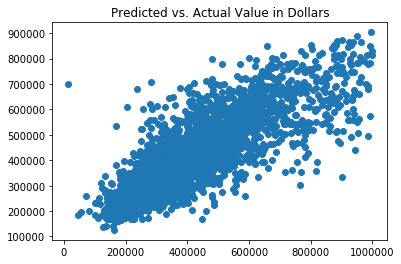

In [21]:
plt.scatter(x=response_actual, y=response_predicted);
plt.title("Predicted vs. Actual Value in Dollars");

# K selection: an heuristic approach

The selection of the parameter K can be done using an heuristic approach.

Split the __training dataset__ in two different parts (rndomly), one parts used for training the model and the other part used for evaluation the model based on different K values. __The K that minimize the MAE is the one that should be selected__.

The idea is to not to use the __testing dataset__ for the selection of the K parameter. The __testing dataset__ is needed to evaluate the performance of the final model.

In [22]:
data_training, data_testing = data_splitting(dataset = data_cleaned, 
                                             testing_holdout = 0.2)

#Split the training data in two parts (80%, 20%)
#One part to fit the model with a certain K
#The other part to evaluate the model (MAE)
random.seed(201704)
part1_rows = random.sample(list(data_training.index), int(round(len(data_training) * 0.2)))
part2_rows = set(range(len(data_training))) - set(part1_rows)

part1_test = data_training.ix[part1_rows]
part2_train = data_training.drop(part1_rows)

#Training
part2_train_response = part2_train.AppraisedValue
part2_train_predictors = part2_train.drop(["AppraisedValue"], 1)

#Testing
part1_test_response = part1_test.AppraisedValue
part1_test_predictors = part1_test.drop(["AppraisedValue"], 1)

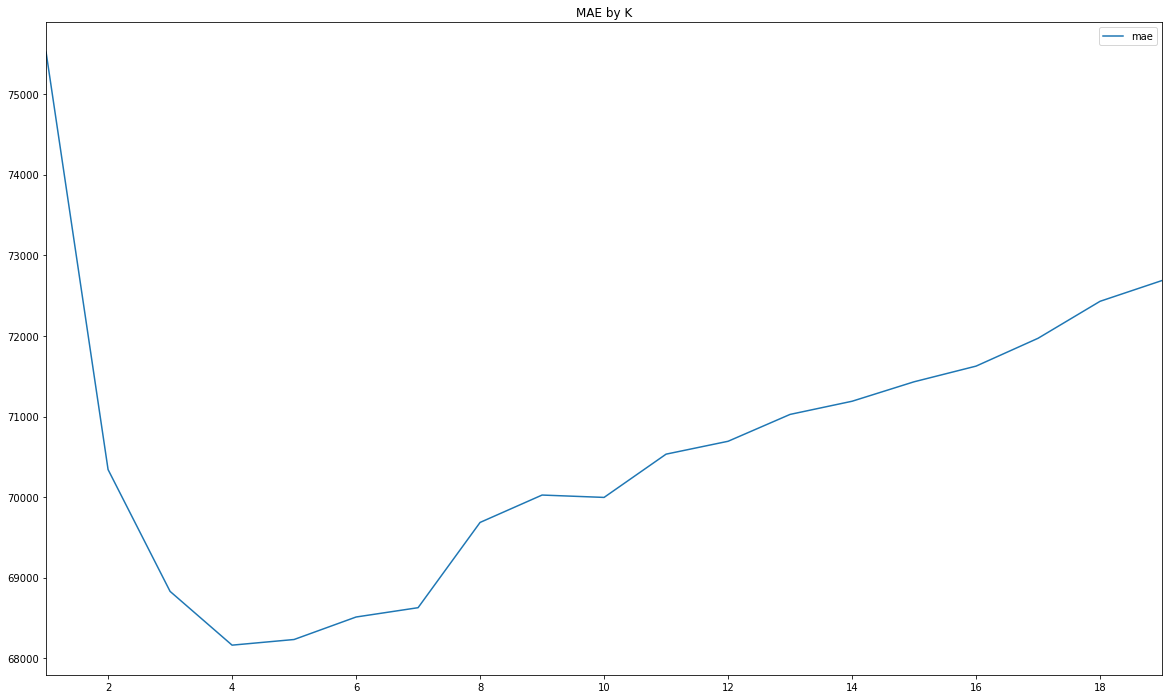

In [23]:
ks = []
maes = []

for k in range(1,20):
    kd_tree_model = KDTree(part2_train_predictors)
    ks.append(k)
    response_actual = []
    response_predicted = []
    
    for idx, row in part1_test_predictors.iterrows():
        response_predicted.append(predict(model = kd_tree_model,
                                         model_response = part2_train_response,
                                         new_entry = row, 
                                          k = k))
        response_actual.append(part1_test_response.loc[idx])
    
    maes.append(metrics.mean_absolute_error(
                    y_pred=response_predicted, 
                    y_true=response_actual))

res = pd.DataFrame({"mae": maes}, index=ks)
res.plot(title = "MAE by K")
plt.gcf().set_size_inches(20, 12, forward=False)
plt.show()

Based on the __"MAE by K" output__, __the best K that minimize the MAE is 4__. 

If we test the KNN model using K = 4 and the testing dataset then

In [24]:
testing_response = data_testing.AppraisedValue
testing_predictors = data_testing.drop(["AppraisedValue"], 1)

In [25]:
k = 4
kd_tree_model = KDTree(training_predictors)

In [26]:
response_actual = []
response_predicted = []

for idx, row in testing_predictors.iterrows():
    response_predicted.append(predict(model = kd_tree_model,
                                     model_response = training_response,
                                     new_entry = row, 
                                      k = k))
    response_actual.append(testing_response.loc[idx])

print("MAE: %0.3f dollars" %metrics.mean_absolute_error(
                    y_pred=response_predicted, 
                    y_true=response_actual))
print("R^2: %0.3f" % metrics.r2_score(
                    y_pred=response_predicted, 
                    y_true=response_actual))

MAE: 69430.584 dollars
R^2: 0.695


# Environment Information

    MacBook Pro, macOS Sierra v.10.12.4
    conda 4.3.15
    Python 3.5.2 :: Anaconda 4.3.0 (x86_64)

    pandas                    0.19.2              np111py35_1
    numpy                     1.11.3                   py35_0
    scikit-learn              0.18.1              np111py35_1  
    scipy                     0.18.1              np111py35_1
    matplotlib                2.0.0               np111py35_0 
    basemap                   1.0.7               np111py35_0 
